In [63]:
from enm import *
from prody import *
from pylab import *

from MDAnalysis import *
from MDAnalysis.analysis.gnm import GNMAnalysis as GNM
from MDAnalysis.analysis.encore.covariance import covariance_matrix
from MDAnalysis.analysis import align
from MDAnalysis import transformations
from multiprocessing import cpu_count
from multiprocessing import Pool
from functools import partial
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import eig
import matplotlib.pyplot as plt


In [5]:
print(cpu_count())

64


In [48]:
# loaded MD trajectory and topology.
n_cores = cpu_count()
topology = "./../testvmd/md_0_1.tpr"
trajectory = "./../testvmd/md_0_1.xtc"

reference = Universe('./../testvmd/md_0_1.gro')
u = Universe(topology, trajectory)
# print(u.fragments)
prot = u.select_atoms("protein")
ag = prot.atoms

transform = transformations.NoJump(max_threads=n_cores, parallelizable=True, check_continuity=True)
# transform_wrap = transformations.wrap(ag, max_threads=n_cores, parallelizable=True)

u.trajectory.add_transformations(transform)
reference_frame = u.trajectory[0]

aligner = align.AlignTraj(u, reference=u, select="protein", in_memory=True, max_cores=n_cores)
aligner.run()
calphasMD = u.select_atoms("protein")


mdcov = covariance_matrix(u, select="name CA")

/home/assylzhanb/.local/lib/python3.10/site-packages/MDAnalysis/transformations/nojump.py:145: UserWarning: NoJump transform is only accurate when positionsdo not move by more than half a box length.Currently jumping between frames with a step of more than 1.This might be fine, but depending on the trajectory stride,this might be inaccurate.
  warnings.warn(
/home/assylzhanb/.local/lib/python3.10/site-packages/MDAnalysis/transformations/nojump.py:135: UserWarning: NoJump detected that the interval between frames is unequal.We are resetting the reference frame to the current timestep.
  warnings.warn(


In [49]:
print(u.trajectory[0])

< Timestep 0 with unit cell dimensions [70.30955  70.30955  70.30953  59.999992 59.999992 90.      ] >


@> 872 atoms and 1 coordinate set(s) were parsed in 0.03s.


@> Hessian was built in 0.05s.
@> 20 modes were calculated in 0.04s.


(354, 354)
(354, 354)


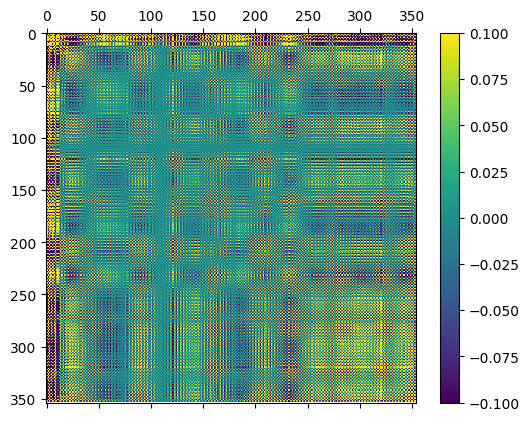

[-0.09144434  0.09883792]


In [64]:
ion()
znw = parsePDB("./../testvmd/AF-O53675-F1-model_v4.pdb")
calphasANM = znw.select("calpha")
anm = ANM('znw ANM analysis')
anm.buildHessian(calphasANM, cutoff = 11.)

# # anm.setHessian(H)
anm.calcModes()

print(anm.getHessian().shape)
anmcov = calcCovariance(anm[:3])
print(anmcov.shape)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(anmcov, vmin=-0.1, vmax=0.1)
# cax = ax.matshow(mdcov)
fig.colorbar(cax)
plt.show()
print(np.quantile(anmcov.ravel(), [0.1, 0.9]))


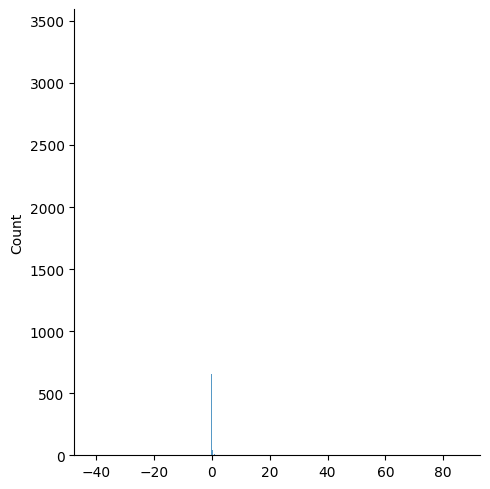

In [16]:
import seaborn as sns
sns.displot(anmcov.ravel())

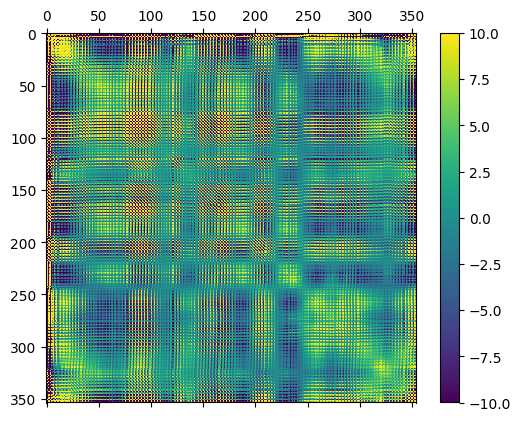

[-9.01957897  9.16902991]


In [51]:
# ! MD COVARIANCE MATRIX PLOT
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mdcov, vmin=-10, vmax=10)
# cax = ax.matshow(mdcov)
fig.colorbar(cax)
plt.show()
print(np.quantile(mdcov.ravel(), [0.1, 0.9]))

[-9.01957897  9.16902991]


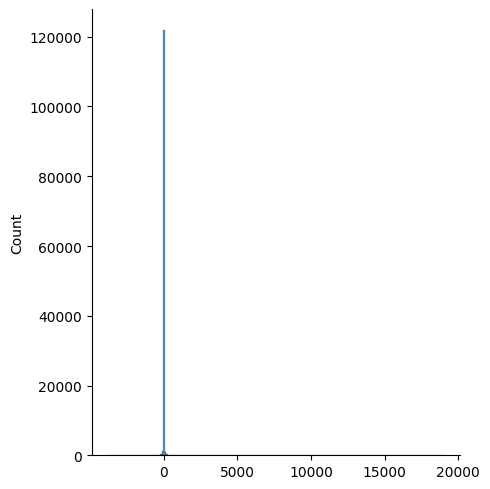

In [75]:
import seaborn as sns
sns.displot(mdcov.ravel(), binwidth=100)
print(np.quantile(mdcov.ravel(), [0.1, 0.9]))

/home/assylzhanb/Desktop/soldier_girl/ENM/enm/enm.py:322: RuntimeWarning: invalid value encountered in divide
  rij = rij / np.linalg.norm(rij, axis=1).reshape(-1, 1)


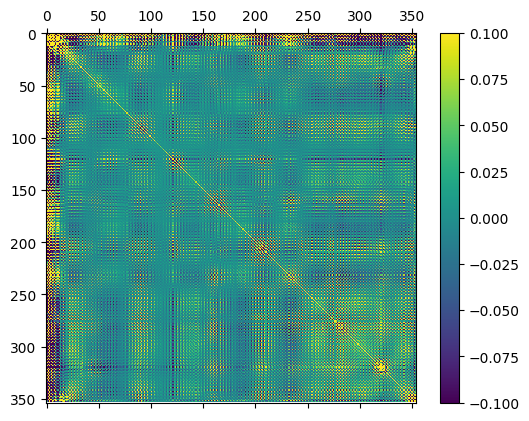

[-0.05056198  0.05301161]


In [65]:
# ! ENM COVARIANCE MATRIX PLOT

a = ENM('./../testvmd/AF-O53675-F1-model_v4.pdb')
a = a.filter('CA')
b = ENM(a.getCoords())
H = a.getHessian(adj = 'cutOff')
# anm = ANM("Using external Hessian")

# covariances = inverse_hessian.copy()
def calculate_covariance_matrix(hessian):
    inverse_hessian = np.linalg.pinv(hessian)
    variances = np.diag(inverse_hessian)

    covariance_matrix = inverse_hessian.copy()
    covariance_matrix = covariance_matrix * 0.5
    

    return covariance_matrix


cov_enm = calculate_covariance_matrix(H)

# sns.displot(covariances.ravel())
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov_enm, vmin=-0.1, vmax=0.1)
# cax = ax.matshow(cov_enm)
fig.colorbar(cax)
plt.show()
print(np.quantile(cov_enm.ravel(), [0.1, 0.9]))

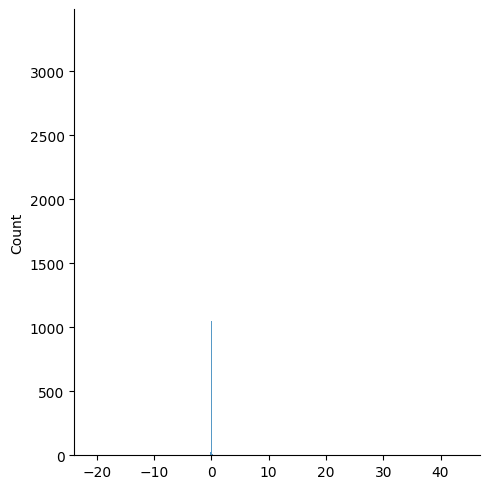

In [20]:
sns.displot(cov_enm.ravel())

In [66]:
# Normalize the covariance matrix
def standardize(matrix):
    mean = np.mean(matrix)
    std_dev = np.std(matrix)
    standardized_matrix = (matrix - mean) / std_dev
    return standardized_matrix

# only upper triangle of md cov matrix
tri_mdcov = np.triu(mdcov, k=1)
tri_enmcov = np.triu(cov_enm, k=1)
tri_anmcov = np.triu(anmcov, k=1)

std_md_cov = standardize(tri_mdcov)
std_enm_cov = standardize(tri_enmcov)
std_anm_cov = standardize(tri_anmcov)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.05752623  0.07216658]


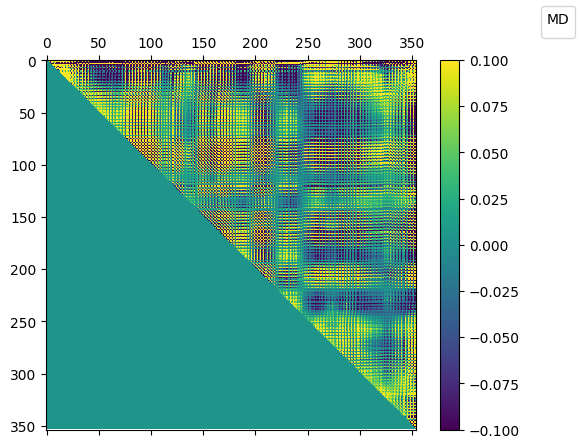

In [67]:
print(np.quantile(std_md_cov.ravel(), [0.1, 0.9]))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(std_md_cov, vmin=-0.1, vmax = 0.1)
# cax = ax.matshow(std_md_cov)
fig.legend( loc="upper right", title="MD")
fig.colorbar(cax)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.17268255  0.18348989]


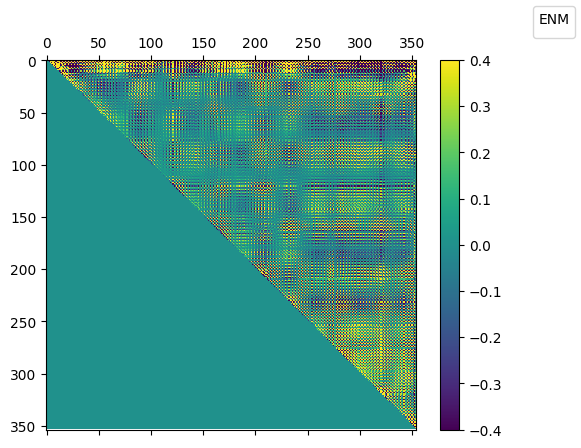

In [68]:
print(np.quantile(std_enm_cov.ravel(), [0.1, 0.9]))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(std_enm_cov, vmin=-0.4, vmax = 0.4)
# cax = ax.matshow(std_anm_cov, vmin=-0.1, vmax=0.1)
fig.colorbar(cax)
# add legend above the plot
fig.legend( loc="upper right", title="ENM")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.17268255  0.18348989]


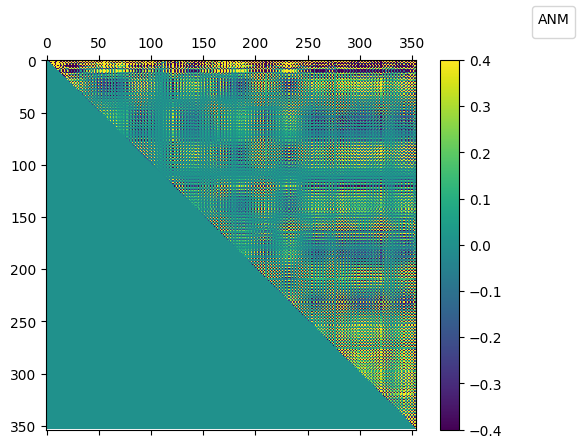

In [69]:
print(np.quantile(std_enm_cov.ravel(), [0.1, 0.9]))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(std_anm_cov, vmin=-0.4, vmax = 0.4)
# cax = ax.matshow(std_anm_cov, vmin=-0.1, vmax=0.1)
fig.colorbar(cax)
# add legend above the plot
fig.legend( loc="upper right", title="ANM")
plt.show()

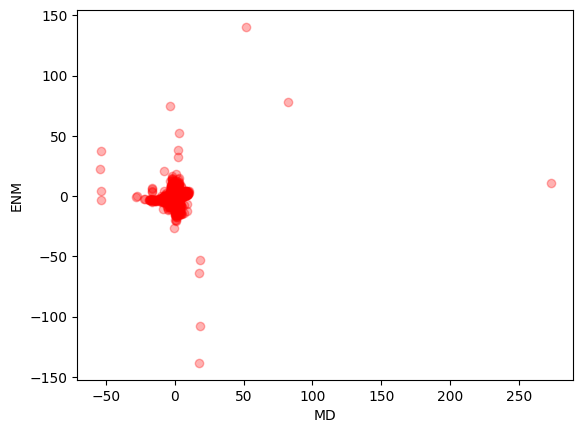

In [57]:
# plot scatter plot of the two matrices both on the same axis but with different colors
idx = np.triu_indices(std_md_cov.shape[0], k=1)
plt.scatter(std_md_cov[idx], std_enm_cov[idx], c='r', marker='o', alpha=0.3)
#plt.scatter(std_anm_cov, std_md_cov, c='b', marker='o')
# add legend above the plot
plt.xlabel('MD')
plt.ylabel('ENM')
plt.show()


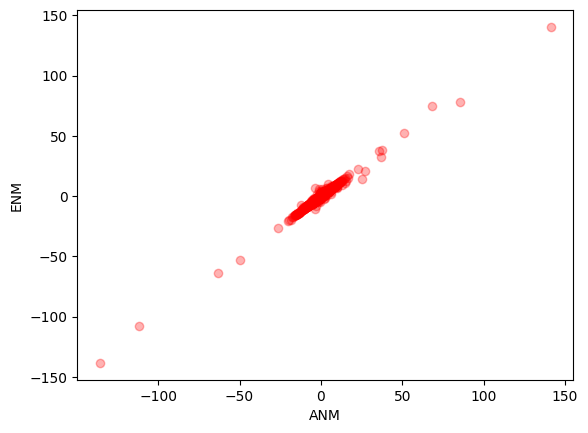

In [58]:
idx = np.triu_indices(std_anm_cov.shape[0], k=1)
plt.scatter(std_anm_cov[idx], std_enm_cov[idx], c='r', marker='o', alpha=0.3)
#plt.scatter(std_anm_cov, std_md_cov, c='b', marker='o')
# add legend above the plot
plt.xlabel('ANM')
plt.ylabel('ENM')
plt.show()

In [74]:
import seaborn as sns
from scipy.linalg import sqrtm, eigh
from scipy.stats import chi2
import inspect
from scipy.stats import pearsonr
import pprint
print(pearsonr(std_anm_cov[idx], std_md_cov[idx]))

source_code = inspect.getsource(bht_dist)

# Print the source code
# pprint.pprint(source_code)
print(source_code)
# print the bhat coeff where it is the e**-bht_dist
print(bht_dist(std_enm_cov, std_anm_cov))
print(np.exp(-bht_dist(std_enm_cov, std_md_cov)))


PearsonRResult(statistic=0.10498360872863916, pvalue=1.321726247511022e-152)
('def bht_dist(covariance_matrix1, covariance_matrix2):\n'
 '    avg_covariance_matrix = (covariance_matrix1 + covariance_matrix2) / 2.0\n'
 '    eigenvalues, eigenvectors = eigh(avg_covariance_matrix)\n'
 '    \n'
 '    idx = np.argsort(eigenvalues)[::-1]\n'
 '    eigenvalues = eigenvalues[idx]\n'
 '    eigenvectors = eigenvectors[:, idx]\n'
 '    \n'
 '    cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)\n'
 '    q = np.argmax(cumulative_variance >= 0.95) + 1\n'
 '    principal_components = eigenvectors[:, :q]\n'
 '    \n'
 '    \n'
 '    proj_covariance_matrix1 = np.dot(np.dot(principal_components.T, '
 'covariance_matrix1), principal_components)\n'
 '    proj_covariance_matrix2 = np.dot(np.dot(principal_components.T, '
 'covariance_matrix2), principal_components)\n'
 '    \n'
 '    \n'
 '    avg_covariance_matrix_proj = (proj_covariance_matrix1 + '
 'proj_covariance_matrix2) / 2.0\n'
 '  

In [18]:

idx = np.triu_indices(cov_enm.shape[0], k=1)
print("ENM and MD:",pearsonr(cov_enm[idx], mdcov[idx]))
print("ENM and ANM:",pearsonr(cov_enm[idx], anmcov[idx]))

print("ANM and MD:", pearsonr(anmcov[idx], mdcov[idx]))
# print(pearsonr(anmcov[idx], mdcov[idx]))
X, Y = cov_enm[idx], mdcov[idx]
idx = (Y > -10) & (Y < 10)
print(pearsonr(X[idx], Y[idx]))
sns.regplot(x=X[idx], y=Y[idx])

ENM and MD: PearsonRResult(statistic=0.09318301252036562, pvalue=1.640636340051297e-120)
ENM and ANM: PearsonRResult(statistic=0.992585446911314, pvalue=0.0)
ANM and MD: PearsonRResult(statistic=0.10498360872863921, pvalue=1.321726247508314e-152)
PearsonRResult(statistic=0.18560674483521905, pvalue=0.0)


NameError: name 'sns' is not defined

### Low **statistic** means that there's very little correlation.
---
### Pvalue = Pearson correlation coefficient. If P-value is less than **0.05** there is a **Non-zero** correlation, but it's very weak. 
```
correlation is unlikely to be due to random chance. 
```

  0%|          | 0/10001 [00:00<?, ?it/s]

[48.49634348 48.53089197 48.48842927 48.56514217 48.41902023 48.39975236
 48.41840157 48.44898992 48.45890342 48.38460951 48.35686267 48.3971102
 48.45983644 48.5366299  48.57722255 48.57311631 48.56527891 48.43725395
 48.52451994 48.39222793]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


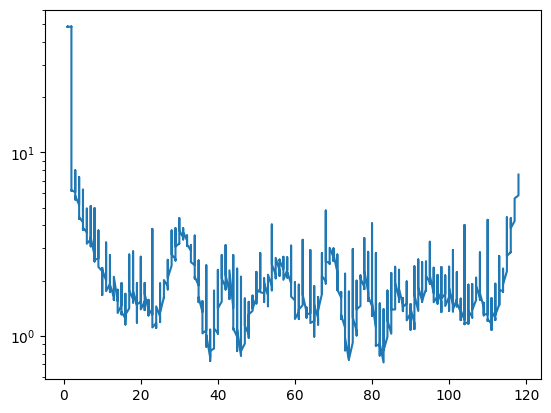

In [151]:
from MDAnalysis.analysis.rms import RMSF
rmsfer = RMSF(calphasMD, verbose=True).run()
fig, ax = plt.subplots()
ax.plot(calphasMD.resnums, rmsfer.results.rmsf)
ax.set_yscale('log')
print(rmsfer.results.rmsf.shape)
print(rmsfer.results.rmsf[:20])
print(calphasMD.resnums[0:20])


/home/msroot/Desktop/soldier_girl/ENM/enm/enm.py:293: RuntimeWarning: invalid value encountered in divide
  rij = rij / np.linalg.norm(rij, axis=1).reshape(-1, 1)


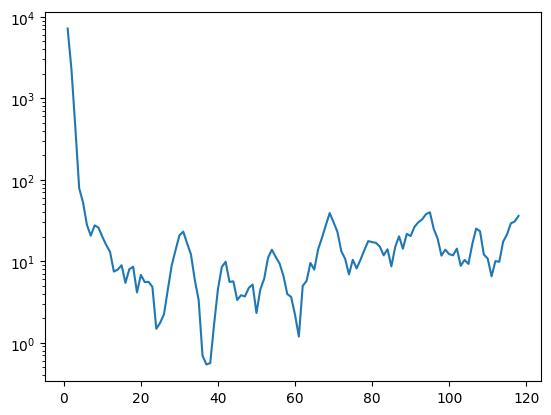

In [149]:
def get_enm_displacement(model, **kwargs):
    H = model.getHessian(**kwargs)
    val, vec = np.linalg.eig(H) # eigenvalues and eigenvectors
    idx = np.argsort(val)[6:] # exclude the first 6 modes
    disp = np.sum(vec[:,idx]**2 / val[idx]**2, axis=1) # displacement
    return disp
enm_disp_array = get_enm_displacement(a)   # displacement array
# plot the displacement array
resss = np.arange(1, len(enm_disp_array)//3+1)
fig, ax = plt.subplots()
ax.plot(resss, enm_disp_array.reshape(-1,3).mean(axis=1))
ax.set_yscale('log')




In [68]:
def bhattacharyya_distance(cov1, cov2):
    det1 = np.linalg.det(cov1)
    det2 = np.linalg.det(cov2)
    det_prod = det1 * det2

    # Calculate mean of covariances
    mean_cov = (cov1 + cov2) / 2

    # Calculate log of determinant of mean of covariances
    det_mean_cov = np.linalg.det(mean_cov)

    # Calculate Bhattacharyya distance
    bhat_dist = 0.125 * np.log(det_prod / det_mean_cov)

    return bhat_dist

